<a href="https://colab.research.google.com/github/jangcom/radiat_sci/blob/main/py_radiat_jp_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Pythonで学ぶ放射線科学（サンプル資料）

張宰雄（ジャン・ジェウン）

- 更新：2020年10月
- 作成：2020年09月

---

## 目次

1. [はじめに](#はじめに)
1. [放射線とは](#放射線とは)
1. [預託実効線量](#預託実効線量)
1. [放射平衡](#放射平衡)
1. [効率曲線](#効率曲線)
1. [おわりに](#おわりに)

## はじめに

本ノートブックは、「Pythonで学ぶ放射線科学」のサンプル資料である。本資料で取り上げる例題は、筆者の仮定に基づき作成したものである。

### Pythonとは

![python_logo](https://www.python.org/static/community_logos/python-logo.png)

- [世界ユーザ数第1位](http://pypl.github.io/PYPL.html)：どこでも通用する
- <ins>無料</ins>
- <ins>面白い</ins>
- 読みやすい（お互いのコードを理解しやすい）
- 計算から結果の処理・グラフ作成まで、1か所で実装できる

### Preamble

In [ ]:
import re
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.ticker import ScalarFormatter
from IPython.display import set_matplotlib_formats
from graphviz import Digraph

In [ ]:
# MPL
set_matplotlib_formats('svg')
plt.style.use('ggplot')
clrs = {
    'plot_lc': 'mediumblue',
    'poly_ec': 'black',
    'poly_fc': 'lightcoral',
    'arr': 'mediumblue',
}

In [ ]:
def decay(a0, dec_const, t):
    """Return a NumPy array of decay data"""
    return a0 * np.exp(-dec_const * t)

In [ ]:
def get_daughter_act(a10, lambda1, lambda2, b, t,
                     a20=0):
    """Return daughter activity."""
    part1 = lambda2 / (lambda2 - lambda1)
    part2 = a10 * (np.exp(-lambda1 * t) - np.exp(-lambda2 * t))
    part3 = a20 * np.exp(-lambda2 * t)
    return b * part1 * part2 + part3

In [ ]:
def plt_act(ax, xdata, ydata,
            is_set_xlim=False, xmin=None, xmax=None,
            is_set_ylim=False, ymin=None, ymax=None,
            xlab='Elapsed time $t$ (y)',
            ylab=r'Effective dose rate $\dot{E}(t)$ (' + u'\u03bc' + 'Sv/y)',
            lab=r'$\dot{E}(t)$',
            lc=clrs['plot_lc'], ls='-', zorder=4):
    """Plot activity against elapsed time."""
    # Ticks
    ax.set_xlim(0, 60)
    if is_set_xlim:
        ax.set_xlim(xmin, xmax)
    if is_set_ylim:
        ax.set_ylim(ymin, ymax)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    # Plotting
    ax.plot(xdata, ydata, label=lab, color=lc, ls=ls, zorder=zorder)

In [ ]:
def ge_eff(x, a, b, c):
    """Ge detector efficiency"""
    return np.exp(a + b*np.log(x) + c*np.log(x)**2)

## 放射線とは

### 放射能と放射線

- 放射能：放射線を出す能力
- 放射線：運動エネルギーをもって空間を進行する粒子線及び電磁波
  - 粒子線の例：α線、陽子線
  - 電磁波の例：赤外線、可視光線、紫外線、X線、γ線

出典：[エネ百科「原子力・エネルギー図面集」](https://www.ene100.jp/zumen)

![預託線量の概念図](https://www.ene100.jp/www/wp-content/uploads/zumen/6-1-1.jpg)



### 放射線の利用

- 病気の診断：レントゲン検査、X線CT検査、PET検査など
- 病気の治療：がんの放射線治療、甲状腺亢進症の治療など

出典：[エネ百科「原子力・エネルギー図面集」](https://www.ene100.jp/zumen)

![預託線量の概念図](https://www.ene100.jp/www/wp-content/uploads/zumen/6-2-5.jpg)

## 預託実効線量

【例題】
20歳の放射線業務従事者が液体状の$^{90}$Srを取扱い中、一部を経口摂取してしまった。ホールボディカウンターを用いて摂取量を測定し、実効線量係数を用いて換算した結果、実効線量率は10nSv/hであることが分かった。預託実効線量はいくらか。ただし、$^{90}$Srの生物学的半減期は45年だと仮定する。

### 手計算で積分する

まず、年単位で積分を行うため、10nSv/hを年間実効線量率に変換する。

$\frac{10\,\mathrm{nSv}}{\mathrm{h}}
 \times \frac{24\,\mathrm{h}}{\mathrm{d}}
 \times \frac{365\,\mathrm{d}}{\mathrm{y}}$

この式をPythonコマンドで表して実行すると、次の通りである。

In [ ]:
eff_dose_rate_t0 = 10  # nSv/h
eff_dose_rate_t0 *= 24 * 365
print('実効線量率：{:,} nSv/y、又は'.format(eff_dose_rate_t0))
print('実効線量率：{:.1f} uSv/y'.format(eff_dose_rate_t0 * 1e-3))

実効線量率：87,600 nSv/y、又は
実効線量率：87.6 uSv/y


実効線量率$\dot{E}(t)$は、体内の放射性同位元素が時間$t$とともに指数関数的に減衰することから、次の式で
表すことができる。

$\dot{E}(t) = \dot{E}(0) \exp(-\lambda_{\mathrm{eff}} t)$
 
ここで、$\lambda_{\mathrm{eff}}$は次の式で表される実効（有効）壊変定数である。

$\lambda_{\mathrm{eff}} = \lambda_{\mathrm{phy}} + \lambda_{\mathrm{bio}}$

$\lambda_{\mathrm{phy}}$は$^{90}$Srの物理学的半減期$T_{\mathrm{phy}}=$28.79年を、$\lambda_{\mathrm{bio}}$は例題より与えられた$T_{\mathrm{bio}}=$45年を用い、次の式で計算できる。

$\lambda = \frac{\ln(2)}{T}$

これは、式$A(t) = A(0) \exp(-\lambda t)$を
$\frac{A(t)}{A(0)} = \exp(-\lambda t)$に書き直し、
放射能$A(t)$が初期放射能$A(0)$の半分になる時刻$t_{1/2}$を$T$と表現した式である。すなわち、

$\begin{align}
  \frac{1}{2} &= \exp(-\lambda T) \\
  -\ln(2) &= -\lambda T \\
  \therefore \lambda &= \frac{\ln(2)}{T}
\end{align}$

から得られた式である。

計算結果、

In [ ]:
sr90_half_life_phy = 28.79  # 年
sr90_dec_const_phy = np.log(2) / sr90_half_life_phy
print('Sr-90の物理学的半減期：{:.1f}年'.format(sr90_half_life_phy))
print('Sr-90の物理学的壊変定数：{:.4f}/年'.format(sr90_dec_const_phy))

Sr-90の物理学的半減期：28.8年
Sr-90の物理学的壊変定数：0.0241/年


In [ ]:
sr90_half_life_bio = 45  # 年
sr90_dec_const_bio = np.log(2) / sr90_half_life_bio
print('Sr-90の生物学的半減期：{:.1f}年'.format(sr90_half_life_bio))
print('Sr-90の生物学的壊変定数：{:.4f}/年'.format(sr90_dec_const_bio))

Sr-90の生物学的半減期：45.0年
Sr-90の生物学的壊変定数：0.0154/年


In [ ]:
sr90_dec_const_eff = sr90_dec_const_phy + sr90_dec_const_bio
sr90_half_life_eff = np.log(2) / sr90_dec_const_eff
print('Sr-90の実効半減期：{:.1f}年'.format(sr90_half_life_eff))
print('Sr-90の実効壊変定数：{:.4f}/年'.format(sr90_dec_const_eff))

Sr-90の実効半減期：17.6年
Sr-90の実効壊変定数：0.0395/年


が得られる。

次に、実効線量率を時間の関数としてデータ化する。

In [ ]:
t = np.arange(76)  # 表示する経過時間：0年から75年まで
eff_dose_rate = decay(eff_dose_rate_t0, sr90_dec_const_eff, t)
df = pd.DataFrame({'時間[年]': t,
                   '実効線量率[nSv/y]': eff_dose_rate,
                   '実効線量率[uSv/y]': eff_dose_rate * 1e-3})
df

,時間[年],実効線量率[nSv/y],実効線量率[uSv/y]
0,0,87600.000000,87.600000
1,1,84208.996061,84.208996
2,2,80949.258191,80.949258
3,3,77815.705070,77.815705
4,4,74803.452074,74.803452
...,...,...,...
71,71,5310.865940,5.310866
72,72,5105.281838,5.105282
73,73,4907.655916,4.907656
74,74,4717.680110,4.717680


続いて、以下の式を用いて預託実効線量を計算する。

$E(\tau) = \int_{t_{0}}^{t_{0} + \tau} \dot{E}(t) \mathrm{d}t$

成人の場合、摂取時から50年間の実効線量率を積算した値を、当該年度の実効線量とする。したがって、区間[0,50]で定積分を行う。

積分結果

$$
\begin{align}
  E(50)
  &= \int_{0}^{50}
    [\dot{E}(0) \exp(-\lambda_{\mathrm{eff}} t)]
  \mathrm{d}t \\
  &= -\frac{\dot{E}(0)}{\lambda_{\mathrm{eff}}}
  [\exp(-\lambda_{\mathrm{eff}} t)]_{0}^{50} \\
  &= \frac{\dot{E}(0)}{\lambda_{\mathrm{eff}}}
  [\exp(-\lambda_{\mathrm{eff}} t)]_{50}^{0}
\end{align}
$$

積分結果の演算を行う。

In [ ]:
e0 = df.loc[0, '実効線量率[nSv/y]']
t0 = 0
tau1 = 50
committed_eff_dose_in_nSv = (e0 / sr90_dec_const_eff
                             * (1 - np.exp(-sr90_dec_const_eff * tau1)))
committed_eff_dose_in_uSv = committed_eff_dose_in_nSv*1e-3
committed_eff_dose_in_mSv = committed_eff_dose_in_nSv*1e-6
print('預託実効線量：{:,.1f} nSv、又は'.format(committed_eff_dose_in_nSv))
print('預託実効線量：{:,.1f} mSv'.format(committed_eff_dose_in_mSv))

預託実効線量：1,910,672.1 nSv、又は
預託実効線量：1.9 mSv


計算結果をグラフで表す。

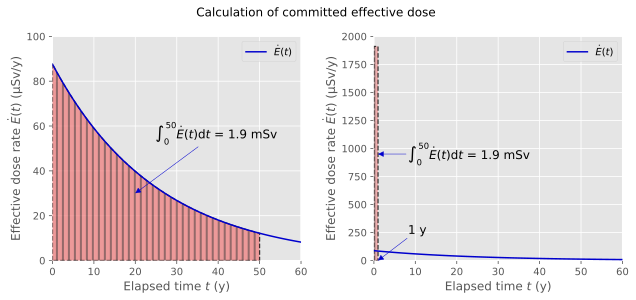

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
poly_attrs = {
    'alpha': 0.75,
    'ec': clrs['poly_ec'],
    'fc': clrs['poly_fc'],
    'hatch': '||',
    'ls': '--',
    'lw': 1.25,
    'zorder': 3,
}
arr_props = {
    'arrowstyle': '-|>',
    'color': clrs['arr'],
    'shrinkA': 0,
    'shrinkB': 0,
}

#
# サブプロット1
#
it1 = np.linspace(t0, tau1)
ie1 = decay(eff_dose_rate_t0*1e-3,  # nSv/y -> uSv/y
            sr90_dec_const_eff, it1)
verts1 = [(t0, 0), *zip(it1, ie1), (tau1, 0)]  # 多角形の頂点（x,y）のリスト

# Area Under the Curveを表示
poly1 = Polygon(verts1, **poly_attrs)
axs[0].add_patch(poly1)
lab = (r'$\int_{0}^{50}'
       + r'\dot{E}(t)\mathrm{d}t$'
       + ' = {:.1f} mSv'.format(committed_eff_dose_in_mSv))
axs[0].annotate(lab,
                xy=(20, 30), xytext=(20, 60), textcoords='offset points',
                arrowprops=arr_props,
                va='center', fontsize=12)

# プロットする
plt_act(axs[0], t, eff_dose_rate*1e-3,  # nSv/y -> uSv/y
        is_set_ylim=True, ymin=0, ymax=100)
axs[0].legend()

#
# サブプロット2
#
tau2 = 1  # 1年まで積分
it2 = np.linspace(t0, tau2, num=2)
ie2 = np.repeat(committed_eff_dose_in_uSv, 2)
verts2 = [(t0, 0), *zip(it2, ie2), (tau2, 0)]  # 多角形の頂点（x,y）のリスト

# Area Under the Curveを表示
poly2 = Polygon(verts2, **poly_attrs)
axs[1].add_patch(poly2)
axs[1].annotate(lab,
                xy=(tau2, 950), xytext=(30, 0), textcoords='offset points',
                arrowprops=arr_props,
                va='center', fontsize=12)
axs[1].annotate('1 y',
                xy=(tau2, 0), xytext=(30, 30), textcoords='offset points',
                arrowprops=arr_props,
                va='center', fontsize=12)

# プロットする
plt_act(axs[1], t, eff_dose_rate*1e-3,  # nSv/y -> uSv/y
        is_set_ylim=True, ymin=0, ymax=2.0e3)
axs[1].legend()

# ポスト処理
fig.suptitle('Calculation of committed effective dose',
             y=1.05, fontsize=12)
fig.tight_layout()

赤色で塗りつぶした領域が、本例題で求めた預託実効線量を示す。

概念図との比較

本資料で作成したグラフの理解を深めるために、概念図を示す。ただし、下記について注意する。

- 下の概念図ではy軸ラベルが「線量」となっているが、正確には「線量率」である。
- また、右側のグラフは、「0\~1年」、「1\~50年」の間の間隔をみると分かるように、x軸のスケールが正しくない。

出典：[エネ百科「原子力・エネルギー図面集」](https://www.ene100.jp/zumen)

![預託線量の概念図](https://www.ene100.jp/www/wp-content/uploads/zumen/6-3-9.jpg)

最後に、例題では「摂取量を測定し実効線量係数を用いて換算した結果、実効線量率は10nSv/hだった」と述べており、摂取量と実効線量係数の値は明らかになっていない。そこで、摂取量が740MBqだったと仮定すると、成人の経口摂取による$^{90}$Srの実効線量係数は

In [ ]:
sr90_intake = 7.4e8  # Bq
eff_dose_conv_coeff = committed_eff_dose_in_mSv / sr90_intake
print('実効線量係数: {:.1e} mSv/Bq'.format(eff_dose_conv_coeff))

実効線量係数: 2.6e-09 mSv/Bq


である。

### SciPyを用いて積分する

- [SciPy](https://docs.scipy.org/doc/scipy/reference/index.html)とは、科学計算で必要な様々な関数・パッケージを提供するPythonライブラリである。
- 以下で、SciPyのサブパッケージ「[scipy.integrate](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)」を用いて実効線量率の定積分を行ってみる。

In [ ]:
integrand = lambda t: eff_dose_rate_t0 * np.exp(-sr90_dec_const_eff * t)
scipy_result = integrate.quad(integrand, t0, t0 + tau1)
print('預託実効線量：{:,.1f} nSv、又は'.format(scipy_result[0]))
print('預託実効線量：{:,.1f} mSv'.format(scipy_result[0] * 1e-6))

預託実効線量：1,910,672.1 nSv、又は
預託実効線量：1.9 mSv


[手計算で求めた積分結果](#手計算で積分する)と全く同じ結果が得られることが分かる。

- このようなパッケージは非常に便利であるが、入力したコマンドが正しくなくても結果は出るため、式を理解していない場合には誤った計算になる可能性がある。
- 従って、なるべく手計算で計算を行い、確認のためパッケージを利用することが望ましい。

### まとめ

本例題での計算過程をまとめると下記の通りである。

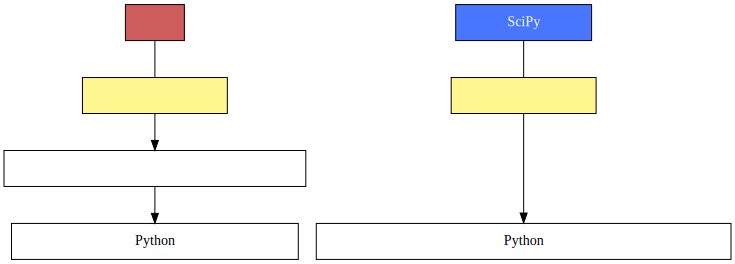

In [ ]:
g = Digraph()
g.attr('node', shape='record')

# 手計算
g.node('h1', '手計算',
       style='filled', fillcolor='indianred', fontcolor='white')
g.node('h2', '実効壊変定数を計算',
       style='filled', fillcolor='khaki1')
g.node('h3', '実効線量率を摂取後経過時間に対して定積分')
g.node('h4', 'Pythonを用いて、積分で得られた式を演算')
g.edge('h1', 'h2', dir='none')
g.edges([('h2', 'h3'),
         ('h3', 'h4')])

# SciPyを用いた計算
g.node('s1', 'SciPyを用いた計算',
       style='filled', fillcolor='royalblue1', fontcolor='white')
g.node('s2', '実効壊変定数を計算',
       style='filled', fillcolor='khaki1')
g.node('s3', 'Pythonを用いて、実効線量率を摂取後経過時間に対して定積分')
g.edge('s1', 's2', dir='none')
g.edge('s2', 's3')

# Rank constraints
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('h1')
    s.node('s1')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('h2')
    s.node('s2')
with g.subgraph() as s:
    s.attr(rank='same')
    s.node('h4')
    s.node('s3')

# Show on Colab
g

いずれのステップも、時間の単位に注意する必要がある。

## 放射平衡

### 過渡平衡

過渡平衡とは、娘核種の壊変定数$\lambda_{2}$が親核種の壊変定数$\lambda_{1}$より高く、平衡が成り立てる十分な時間が経過したとき成立される平衡状態をいう。すなわち、

$\lambda_{1} < \lambda_{2}$

の関係を持つ親核種と娘核種の間に過渡平衡が成り立てる。その理由を下記に述べる。

親核種とその娘核種の時間経過に伴う原子数$N$は、それぞれ

$\begin{align}
  \frac{\textrm{d}N_{1}}{\textrm{d}t} &= -\lambda_{1} N_{1} \\
  \frac{\textrm{d}N_{2}}{\textrm{d}t} &= \lambda_{1} N_{1} -\lambda_{2} N_{2}
\end{align}$

で表される（[Bateman方程式](https://en.wikipedia.org/wiki/Bateman_equation#:~:text=In%20nuclear%20physics%2C%20the%20Bateman,by%20Harry%20Bateman%20in%201910.)）。

上記の微分方程式を連立して解くと、親核種とその娘核種のそれぞれの放射能式が得られる。本資料では[連立微分方程式を解く過程](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.20.104701)は省略し、結果のみを示す。結果は下記の通りである。

$\begin{align}
  A_{1}(t) &= A_{1}(0) \exp(-\lambda_{1} t) \\
  A_{2}(t) &= B \left\{
    \frac{\lambda_{2}}
         {\lambda_{2} - \lambda_{1}}
    A_{1}(0)
    \left[
      \exp(-\lambda_{1} t) - \exp(-\lambda_{2} t)
    \right]
    \right\} + A_{2}(0) \exp(-\lambda_{2} t)
\end{align}$

ここで、$B$は核種$1$が$2$に壊変する確率「branching ratio」を示す。

上記で述べたように、過渡平衡条件は

$\lambda_{1} < \lambda_{2}$

である。従って、$A_{2}(t)$の式で次の関係が成立する。

$\exp(-\lambda_{2} t) \to 0$、ただし、$\exp(-\lambda_{1} t) \neq 0$

そのため、$A_{2}(t)$の式は
\begin{equation}
  A_{2}(t)
  \approx B
  \frac{\lambda_{2}}
       {\lambda_{2} - \lambda_{1}}
  A_{1}(t)
  + A_{2}(0) \exp(-\lambda_{2} t)
\end{equation}
に近似できる。また、通常$A_{2}(0) = 0$であるため、$A_{2}(t)$は
\begin{equation}
  A_{2}(t)
  \approx B
  \frac{\lambda_{2}}
       {\lambda_{2} - \lambda_{1}}
  A_{1}(t)
\end{equation}
に表すことができ、これを書き直すと、
\begin{equation}
  \frac{A_{2}(t)}{A_{1}(t)}
  \approx B
  \frac{\lambda_{2}}
       {\lambda_{2} - \lambda_{1}}
\end{equation}
になる。

ただし、上記の近似式は$\exp(-\lambda_{2} t) \to 0$になる時刻$t$で成り立つことに注意。

まとめると、$\exp(-\lambda_{2} t) \to 0$になるような十分な時間が経ったとき、娘核種と親核種の間には過渡平衡が成立し、その放射能の比は$B \frac{\lambda_{2}}{\lambda_{2} - \lambda_{1}}$になる。

---

以下、過渡平衡の実例を用いてグラフを作成してみる。

核医学で多く利用される$^{99\textrm{m}}$Tcは、その親核種である$^{99}$Moと過渡平衡を成立する。関連する壊変は下記の通りである。

$^{99}$Mo
$\xrightarrow[65.94\,\mathrm{h}]{\beta^{-}}$
$^{99\mathrm{m}}$Tc
$\xrightarrow[6\,\mathrm{h}]{\mathrm{IT}}$
$^{99}$Tc
$\xrightarrow[2.1\times10^{5}\,\mathrm{y}]{\beta^{-}}$
$^{99}$Ru

[預託実効線量](#預託実効線量)で述べたように、$\lambda$は半減期$T$と$\lambda = \frac{\ln(2)}{T}$の関係を持つ。したがって、$^{99}$Moと$^{99\textrm{m}}$Tcの半減期及び壊変定数はそれぞれ

In [ ]:
mo99_half_life_phy = 65.94  # 時間
mo99_dec_const_phy = np.log(2) / mo99_half_life_phy
print('Mo-99の（物理学的）半減期：{:.2f}時間'.format(mo99_half_life_phy))
print('Mo-99の（物理学的）壊変定数：{:.4f}/時間'.format(mo99_dec_const_phy))

Mo-99の（物理学的）半減期：65.94時間
Mo-99の（物理学的）壊変定数：0.0105/時間


In [ ]:
tc99m_half_life_phy = 6.01  # 時間
tc99m_dec_const_phy = np.log(2) / tc99m_half_life_phy
print('Mo-99の（物理学的）半減期：{:.2f}時間'.format(tc99m_half_life_phy))
print('Mo-99の（物理学的）壊変定数：{:.4f}/時間'.format(tc99m_dec_const_phy))

Mo-99の（物理学的）半減期：6.01時間
Mo-99の（物理学的）壊変定数：0.1153/時間


である。

また、$^{99}$Moの$^{99\mathrm{m}}$Tcへのbranching ratioは$B \approx 0.875$である。したがって、過渡平衡は$^{99\mathrm{m}}$Tcと$^{99}$Moの放射能比が

In [ ]:
b = 0.875
tr_equil = b * tc99m_dec_const_phy / (tc99m_dec_const_phy - mo99_dec_const_phy)
print('{:.4f}'.format(tr_equil))

0.9627


になる時刻$t$に成り立つ。また、この$t$で$\exp(-\lambda_{2} t) \to 0$になる。

今、$t = 0$での初期放射能$A_{1}(0) = 100$ MBq、$A_{2}(0) = 0$ MBqを仮定し、$A_{1}(t)$と$A_{2}(t)$を計算すると以下の通りである。

In [ ]:
t = np.arange(101)  # 0~100時間

a10 = 100  # MBq
a20 = 0

a1 = decay(a10, mo99_dec_const_phy, t)
a2 = get_daughter_act(a10, mo99_dec_const_phy, tc99m_dec_const_phy, b, t)
a2_over_a1 = a2 / a1
lambda2_exp_dec = np.exp(-tc99m_dec_const_phy * t)

df = pd.DataFrame({'時間[時間]': t,
                   'Mo-99放射能[MBq]': a1,
                   'Tc-99m放射能[MBq]': a2,
                   'Tc-99m放射能 / Mo-99放射能': a2_over_a1,
                   'exp(-lambda_{2} * t)': lambda2_exp_dec})
df.head(60)

,時間[時間],Mo-99放射能[MBq],Tc-99m放射能[MBq],Tc-99m放射能 / Mo-99放射能,exp(-lambda_{2} * t)
0,0,100.000000,0.000000,0.000000,1.000000
1,1,98.954327,9.480498,0.095807,0.891070
2,2,97.919588,17.829150,0.182080,0.794006
3,3,96.895669,25.170285,0.259767,0.707515
4,4,95.882458,31.614677,0.329723,0.630445
5,5,94.879841,37.261024,0.392718,0.561771
6,6,93.887708,42.197262,0.449444,0.500577
7,7,92.905949,46.501736,0.500525,0.446049
8,8,91.934457,50.244247,0.546522,0.397461
9,9,90.973123,53.486985,0.587943,0.354166


$t \approx 24$時間から徐々に過渡平衡に収束することが分かる。

上記の計算結果をグラフで表示する。

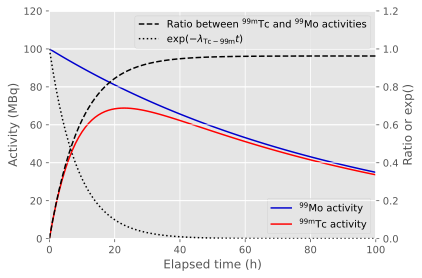

In [ ]:
fig, ax = plt.subplots()
xlab = 'Elapsed time (h)'
ylab = r'Activity (MBq)'
ylab2 = 'Ratio or exp()'

# プロッティング
plt_act(ax, t, a1,
        is_set_xlim=True, xmin=0, xmax=100,
        is_set_ylim=True, ymin=0, ymax=120,
        xlab=xlab, ylab=ylab, lab=r'$^{99}$Mo activity')
plt_act(ax, t, a2,
        is_set_xlim=True, xmin=0, xmax=100,
        is_set_ylim=True, ymin=0, ymax=120,
        xlab=xlab, ylab=ylab, lab=r'$^{99\mathrm{m}}$Tc activity',
        lc='red')
ax.legend(loc='lower right')
ax2 = ax.twinx()
plt_act(ax2, t, a2_over_a1,
        is_set_xlim=True, xmin=0, xmax=100,
        is_set_ylim=True, ymin=0, ymax=1.2,
        xlab=xlab, ylab=ylab2,
        lab=r'Ratio between $^{99\mathrm{m}}$Tc and $^{99}$Mo activities',
        lc='black', ls='--')
plt_act(ax2, t, lambda2_exp_dec,
        is_set_xlim=True, xmin=0, xmax=100,
        is_set_ylim=True, ymin=0, ymax=1.2,
        xlab=xlab, ylab=ylab2, lab=r'$\exp(-\lambda_{\mathrm{Tc-99m}} t)$',
        lc='black', ls='dotted')
ax2.legend()

# ポスト処理
fig.tight_layout()

$\exp(-\lambda_{2} t) \to 0$に伴い、$^{99\mathrm{m}}$Tcと$^{99}$Moの間に過渡平衡が成立し、その放射能の比は$B \frac{\lambda_{2}}{\lambda_{2} - \lambda_{1}} = 0.9627$になることが確認できる。

### 永続平衡

永続平衡は、娘核種の壊変定数が親核種の壊変定数より非常に高いとき成り立てる。すなわち、

$\lambda_{1} \ll \lambda_{2}$

となり、$\lambda_{1} \approx 0$とみなすことができるので、$A_{2}(t)$は

$
  A_{2}(t)
  \approx B A_{1}(0)
  \left[
    1 - \exp(-\lambda_{2} t)
  \right]
$

と近似できる。[過渡平衡](#過渡平衡)と同じく、$\exp(-\lambda_{2} t) \to 0$になるような時間が経ったとき、娘核種と親核種の間に永続平衡が成立する。そのときの放射能の比は

$
  \frac{A_{2} (t)}
       {A_{1} (t)}
  \approx B
$

になる。

---

[預託実効線量](預託実効線量)で取り上げた$^{90}$Srは、その娘核種である$^{90}$Yと永続平衡を成立する。

$^{90}$Sr
$\xrightarrow[28.79\,\mathrm{y}]{\beta^{-}\,0.564\,\mathrm{MeV}}$
$^{90}$Y
$\xrightarrow[64.0\,\mathrm{h}]{\beta^{-}\,2.28\,\mathrm{MeV}}$
$^{90}$Zr

$^{90}$Srと$^{90}$Yの半減期及び壊変定数はそれぞれ

In [ ]:
sr90_half_life_phy_in_hour = sr90_half_life_phy * 365 * 24  # 時間
sr90_dec_const_phy_in_hour = np.log(2) / sr90_half_life_phy_in_hour
print('Sr-90の物理学的半減期：{:.1f}年'.format(sr90_half_life_phy))
print('Sr-90の物理学的半減期：{:.1f}時間'.format(sr90_half_life_phy_in_hour))
print('Sr-90の物理学的壊変定数：{:.4e}/時間'.format(sr90_dec_const_phy_in_hour))

Sr-90の物理学的半減期：28.8年
Sr-90の物理学的半減期：252200.4時間
Sr-90の物理学的壊変定数：2.7484e-06/時間


In [ ]:
y90_half_life_phy = 64.0  # 時間
y90_dec_const_phy = np.log(2) / y90_half_life_phy
print('Y-90の（物理学的）半減期：{:.2f}時間'.format(y90_half_life_phy))
print('Y-90の（物理学的）壊変定数：{:.4f}/時間'.format(y90_dec_const_phy))

Y-90の（物理学的）半減期：64.00時間
Y-90の（物理学的）壊変定数：0.0108/時間


である。$\lambda_{1} \ll \lambda_{2}$であることが分かる。

今、$t = 0$での初期放射能$A_{1}(0) = 100$ MBq、$A_{2}(0) = 0$ MBqを仮定し、$A_{1}(t)$と$A_{2}(t)$を計算すると以下の通りである。また、$^{90}$Srの$^{90}$Yへのbranching ratioは$B = 1$である。

In [ ]:
t = np.arange(601)  # 0~600時間

a10 = 100  # MBq
a20 = 0
b = 1.  # Sr-90のY-90に壊変率は100%

a1 = decay(a10, sr90_dec_const_phy_in_hour, t)
a2 = get_daughter_act(a10, sr90_dec_const_phy_in_hour, y90_dec_const_phy, b, t)
a2_over_a1 = a2 / a1
lambda2_exp_dec = np.exp(-y90_dec_const_phy * t)

df = pd.DataFrame({'時間[時間]': t,
                   'Sr-90放射能[MBq]': a1,
                   'Y-90放射能[MBq]': a2,
                   'Y-90放射能 / Sr-90放射能': a2_over_a1,
                   'exp(-lambda_{2} * t)': lambda2_exp_dec})
df

,時間[時間],Sr-90放射能[MBq],Y-90放射能[MBq],Y-90放射能 / Sr-90放射能,exp(-lambda_{2} * t)
0,0,100.000000,0.000000,0.000000,1.000000
1,1,99.999725,1.077197,0.010772,0.989228
2,2,99.999450,2.142788,0.021428,0.978572
3,3,99.999175,3.196897,0.031969,0.968031
4,4,99.998901,4.239648,0.042397,0.957603
...,...,...,...,...,...
596,596,99.836330,99.704357,0.998678,0.001573
597,597,99.836055,99.705777,0.998695,0.001556
598,598,99.835781,99.707179,0.998712,0.001539
599,599,99.835506,99.708563,0.998728,0.001522


上記の計算結果をグラフで表示する。

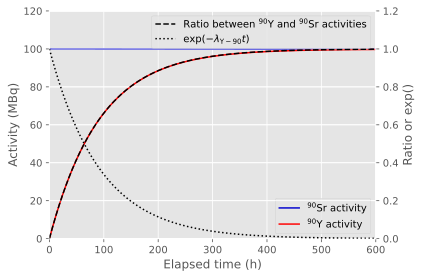

In [ ]:
fig, ax = plt.subplots()
xlab = 'Elapsed time (h)'
ylab = r'Activity (MBq)'
ylab2 = 'Ratio or exp()'

# プロッティング
plt_act(ax, t, a1,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=120,
        xlab=xlab, ylab=ylab, lab=r'$^{90}$Sr activity')
plt_act(ax, t, a2,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=120,
        xlab=xlab, ylab=ylab, lab=r'$^{90}$Y activity',
        lc='red')
ax.legend(loc='lower right')
ax2 = ax.twinx()
plt_act(ax2, t, a2_over_a1,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=1.2,
        xlab=xlab, ylab=ylab2,
        lab=r'Ratio between $^{90}$Y and $^{90}$Sr activities',
        lc='black', ls='--')
plt_act(ax2, t, lambda2_exp_dec,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=1.2,
        xlab=xlab, ylab=ylab2, lab=r'$\exp(-\lambda_{\mathrm{Y-90}} t)$',
        lc='black', ls='dotted')
ax2.legend()

# ポスト処理
fig.tight_layout()

$t \approx 400$時間から徐々に永続平衡に収束することが分かる。

また、$^{90}$Srの半減期は28.79年と長いので、グラフの0~600時間の範囲ではその放射能がほとんど減衰しないことが見える。

### 放射平衡不成立

親核種の壊変定数が娘核種の壊変定数よりも高い場合、娘核種より早く崩壊してしまい放射平衡は成立ない。すなわち、
 
$\lambda_{1} > \lambda_{2}$
 
では放射平衡不成立となる。
 
したがって、[過渡平衡](#過渡平衡)とは逆に次の関係が成立する。
 
$\exp(-\lambda_{1} t) \to 0$、ただし、$\exp(-\lambda_{2} t) \neq 0$
 
そのため、$A_{2}(t)$は
 
$
  A_{2}(t) \approx
  -B
  \frac{\lambda_{2}}
       {\lambda_{2} - \lambda_{1}}
  A_{1}(0)
  \exp(-\lambda_{2} t)
$
 
と近似できる。
 
ただし、上記の近似式は$\exp(-\lambda_{1} t) \to 0$になる時刻$t$で成り立つことに注意。

---

$^{131}$Iは、核医学で甲状腺機能亢進症の治療や甲状腺摂取率の計測に用いられる。主にウランの核分裂生成物として製造供給されるが、ここでは放射平衡不成立の例として、$^{131\mathrm{m}}$Teから$^{131}$Iに壊変する例を取り上げる。$^{131\mathrm{m}}$Teは、77.8%の確率で$^{131}$Iに$\beta^{-}$壊変する。

$^{131\mathrm{m}}$Te
$\xrightarrow[30.0\,\mathrm{h}]{\beta^{-}\,2.234\,\mathrm{MeV}}$
$^{131}$I
$\xrightarrow[8.0\,\mathrm{d}]{\beta^{-}\,0.606\,\mathrm{MeV}}$
$^{131}$Xe

$^{131\mathrm{m}}$Teと$^{131}$Iの半減期及び壊変定数はそれぞれ

In [ ]:
te131m_half_life_phy = 30.  # 時間
te131m_dec_const_phy = np.log(2) / te131m_half_life_phy
print('Te-131mの物理学的半減期：{:.1f}時間'.format(te131m_half_life_phy))
print('Te-131mの物理学的壊変定数：{:.4f}/時間'.format(te131m_dec_const_phy))

Te-131mの物理学的半減期：30.0時間
Te-131mの物理学的壊変定数：0.0231/時間


In [ ]:
i131_half_life_phy = 8.  # 日
i131_half_life_phy_in_hour = i131_half_life_phy * 24  # 時間
i131_dec_const_phy_in_hour = np.log(2) / i131_half_life_phy_in_hour
print('I-131の物理学的半減期：{:.1f}日'.format(i131_half_life_phy))
print('I-131の物理学的半減期：{:.1f}時間'.format(i131_half_life_phy_in_hour))
print('I-131の物理学的壊変定数：{:.4f}/時間'.format(i131_dec_const_phy_in_hour))

I-131の物理学的半減期：8.0日
I-131の物理学的半減期：192.0時間
I-131の物理学的壊変定数：0.0036/時間


である。$\lambda_{1} > \lambda_{2}$であることが分かる。

今、$t = 0$での初期放射能$A_{1}(0) = 100$ MBq、$A_{2}(0) = 0$ MBqを仮定し、$A_{1}(t)$と$A_{2}(t)$を計算すると以下の通りである。また、$^{131\mathrm{m}}$Teの$^{131}$Iへのbranching ratioは$B = 0.778$である。

In [ ]:
t = np.arange(601)  # 0~600時間

a10 = 100  # MBq
a20 = 0
b = 0.778  # Te-131mのI-131に壊変率

a1 = decay(a10, te131m_dec_const_phy, t)
a2 = get_daughter_act(a10, te131m_dec_const_phy, i131_dec_const_phy_in_hour,
                      b, t)
a2_over_a1 = a2 / a1
lambda2_exp_dec = np.exp(-i131_dec_const_phy_in_hour * t)

df = pd.DataFrame({'時間[時間]': t,
                   'Te-131m放射能[MBq]': a1,
                   'I-131放射能[MBq]': a2,
                   'I-131放射能 / Te-131m放射能': a2_over_a1,
                   'exp(-lambda_{2} * t)': lambda2_exp_dec})
df

,時間[時間],Te-131m放射能[MBq],I-131放射能[MBq],I-131放射能 / Te-131m放射能,exp(-lambda_{2} * t)
0,0,100.000000,0.000000,0.000000,1.000000
1,1,97.715997,0.277147,0.002836,0.996396
2,2,95.484160,0.546964,0.005728,0.992806
3,3,93.303299,0.809625,0.008677,0.989228
4,4,91.172249,1.065294,0.011684,0.985663
...,...,...,...,...,...
596,596,0.000105,1.675462,16017.592222,0.116293
597,597,0.000102,1.669425,16332.917831,0.115874
598,598,0.000100,1.663409,16654.450949,0.115456
599,599,0.000098,1.657415,16982.313776,0.115040


上記の計算結果をグラフで表示する。

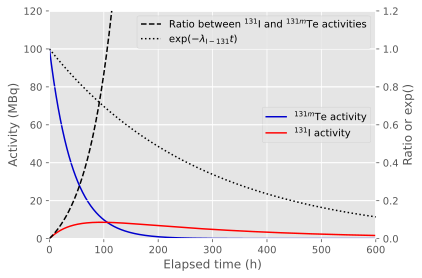

In [ ]:
fig, ax = plt.subplots()
xlab = 'Elapsed time (h)'
ylab = r'Activity (MBq)'
ylab2 = 'Ratio or exp()'

# プロッティング
plt_act(ax, t, a1,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=120,
        xlab=xlab, ylab=ylab, lab=r'$^{131m}$Te activity')
plt_act(ax, t, a2,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=120,
        xlab=xlab, ylab=ylab, lab=r'$^{131}$I activity',
        lc='red')
ax.legend(loc='center right')
ax2 = ax.twinx()
plt_act(ax2, t, a2_over_a1,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=1.2,
        xlab=xlab, ylab=ylab2,
        lab=r'Ratio between $^{131}$I and $^{131m}$Te activities',
        lc='black', ls='--')
plt_act(ax2, t, lambda2_exp_dec,
        is_set_xlim=True, xmin=0, xmax=600,
        is_set_ylim=True, ymin=0, ymax=1.2,
        xlab=xlab, ylab=ylab2, lab=r'$\exp(-\lambda_{\mathrm{I-131}} t)$',
        lc='black', ls='dotted')
ax2.legend()

# ポスト処理
fig.tight_layout()

親核種$^{131\mathrm{m}}$Teが娘核種$^{131}$Iより早く崩壊してしまい、放射平衡は成り立たないことが分かる。

## 効率曲線

- 放射線検出器の検出効率$\varepsilon$とは、検出器に入射された放射線$n$個が計測され$c$個としてカウントされる確率である。すなわち、$\varepsilon = \frac{c}{n}$である。
- 検出効率は、主に下記の要素に依存する。
  - 検出器の種類
  - 放射線の種類
  - 測定する放射線のエネルギー
- 本資料では、Ge半導体検出器を用いてガンマ線を測定する場合を想定し、Pythonを用いて検出効率を作図する方法を示す。

手順

（エネルギー校正等は既に終わっていると仮定する）

1. ガンマ線標準線源を用いてガンマ線測定を行う。校正は、試料を入れる容器や位置ごとに行う必要がある。
1. ガンマ線標準線源の核種ごと測定効率を求め、ガンマ線エネルギーの関数としてデータ化する。
1. データに対してフィッティングを行う。

In [ ]:
# Ge半導体検出器の検出効率データ
ge_eff_data = {
    'ﾋﾟｰｸｴﾈﾙｷﾞ(keV)': [
        50.0,
        80.998,
        122.061,
        136.474,
        276.399,
        302.851,
        356.013,
        383.849,
        569.33,
        604.72,
        661.657,
        795.86,
        834.848,
        1173.23,
        1332.49
    ],
    '核種': [
        np.nan,
        '$^{133}$Ba',
        '$^{57}$Co',
        '$^{57}$Co',
        '$^{133}$Ba',
        '$^{133}$Ba',
        '$^{133}$Ba',
        '$^{133}$Ba',
        '$^{134}$Cs',
        '$^{134}$Cs',
        '$^{137}$Cs',
        '$^{134}$Cs',
        '$^{54}$Mn',
        '$^{60}$Co',
        '$^{60}$Co',
    ],
    '測定効率': [
        0.010000,
        0.028375,
        0.041929,
        0.041587,
        0.026090,
        0.024927,
        0.021645,
        0.021337,
        0.014780,
        0.014291,
        0.013499,
        0.011542,
        0.011755,
        0.008845,
        0.007939,
    ],
}
df = pd.DataFrame(ge_eff_data)

# Offsets for radionuclide annotation
df['offx'] = 0.0
df['offy'] = 0.0
offx_i = 3
offy_i = 4
df.iloc[1, offx_i] = 5
df.iloc[1, offy_i] = -5
df.iloc[2, offx_i] = -15
df.iloc[2, offy_i] = 5
df.iloc[3, offx_i] = -5
df.iloc[3, offy_i] = -15
df.iloc[5, offx_i] = -20
df.iloc[5, offy_i] = -15
df.iloc[7, offx_i] = -20
df.iloc[7, offy_i] = -15
df.iloc[9, offx_i] = -20
df.iloc[9, offy_i] = -15
df.iloc[11, offx_i] = -20
df.iloc[11, offy_i] = -15

df

,ﾋﾟｰｸｴﾈﾙｷﾞ(keV),核種,測定効率,offx,offy
0,50.000,NaN,0.010000,0.0,0.0
1,80.998,$^{133}$Ba,0.028375,5.0,-5.0
2,122.061,$^{57}$Co,0.041929,-15.0,5.0
3,136.474,$^{57}$Co,0.041587,-5.0,-15.0
4,276.399,$^{133}$Ba,0.026090,0.0,0.0
5,302.851,$^{133}$Ba,0.024927,-20.0,-15.0
6,356.013,$^{133}$Ba,0.021645,0.0,0.0
7,383.849,$^{133}$Ba,0.021337,-20.0,-15.0
8,569.330,$^{134}$Cs,0.014780,0.0,0.0
9,604.720,$^{134}$Cs,0.014291,-20.0,-15.0


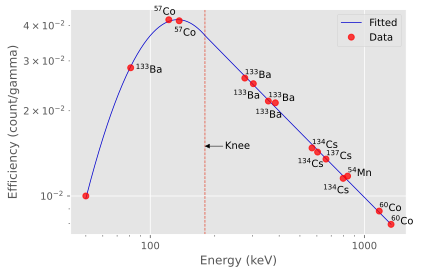

In [ ]:
fig, ax = plt.subplots()
fit_func = ge_eff
xdata_fit_num = 201
knee = 180  # keV
p0_bef_knee = [-3.824022E+001, 1.427534E+001, -1.452642E+000]
p0_from_knee = [1.470955E+000, -1.018902E+000, 1.995309E-002]
stys = {
    'data': {
        'marker': 'o',
        'ls': 'None',
        'color': 'r',
        'alpha': .75,
    },
    'fit': {
        'marker': 'None',
        'ls': '-',
        'lw': .75,
        'color': 'mediumblue',
    },
}

#
# Data
#
xdata = np.array(df.loc[:, 'ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'])
ydata = np.array(df.loc[:, '測定効率'])

#
# Fitting
#

# Before the knee
xdata_bef_knee = list(df.loc[df['ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'] < knee, 'ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'])
ydata_bef_knee = list(df.loc[df['ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'] < knee, '測定効率'])
popt_bef_knee, pcov_bef_knee = curve_fit(fit_func,
                                         xdata_bef_knee, ydata_bef_knee,
                                         p0=p0_bef_knee)
xdata_bef_knee_fit = np.linspace(xdata_bef_knee[0], knee,
                                 num=xdata_fit_num)
ydata_bef_knee_fit = fit_func(xdata_bef_knee_fit, *popt_bef_knee)

# From the knee
# The last (x,y) of bef_knee_fit is prepended to from_knee
# to avoid discontinuity at the knee.
xdata_from_knee = [xdata_bef_knee_fit[-1]] + list(
    df.loc[df['ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'] >= knee, 'ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'])
ydata_from_knee = [ydata_bef_knee_fit[-1]] + list(
    df.loc[df['ﾋﾟｰｸｴﾈﾙｷﾞ(keV)'] >= knee, '測定効率'])
popt_from_knee, pcov_from_knee = curve_fit(fit_func,
                                           xdata_from_knee, ydata_from_knee,
                                           p0=p0_from_knee)
xdata_from_knee_fit = np.linspace(knee, xdata_from_knee[-1],
                                  num=xdata_fit_num)
ydata_from_knee_fit = fit_func(xdata_from_knee_fit, *popt_from_knee)

#
# Ticks etc.
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Efficiency (count/gamma)')
ax.xaxis.set_major_formatter(ScalarFormatter())  # sci -> plain
ax.axvline(knee, ls='--', lw=.75)
ax.annotate('Knee', xy=(knee, 1.5e-2), xytext=(20, 0),
            textcoords='offset points', va='center',
            arrowprops=dict(arrowstyle='-|>', color='k',
                            shrinkA=0, shrinkB=0))

#
# Plotting
#

# Fitting up to before the knee
ax.plot(xdata_bef_knee_fit[:-1], ydata_bef_knee_fit[:-1],
        **stys['fit'], label='Fitted')

# Fitting from the knee
ax.plot(xdata_from_knee_fit, ydata_from_knee_fit,
        **stys['fit'])

# Data
ax.plot(xdata, ydata,
        **stys['data'], label='Data')

# Data point annotation
for i, s in enumerate(df['核種']):
    if re.match('(?i)NaN', str(s)):
        continue
    xcrd = df.iloc[i, 0]
    ycrd = df.iloc[i, 2]
    xoff = df.iloc[i, 3]
    yoff = df.iloc[i, 4]
    ax.annotate(s, xy=(xcrd, ycrd), xytext=(xoff, yoff),
                textcoords='offset points')

#
# Finalizing
#
ax.legend()
fig.tight_layout()

## おわりに

- 本資料では、プログラミング言語「Python」を用い、いくつかの放射線科学の概念について説明した。
- 本資料を通して、放射線、Python、IT技術に興味を持っていただけたら嬉しく思います。